# Reduced demand

## Bringing the data

In [1]:
%reset -f
import copy
import math
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import combinations
from disaggregator import config, data, spatial, plot
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

### Bring the shapes

In [2]:
nuts = data.database_shapes()
nuts = nuts.drop(columns = ["id_ags", "gen", "fl_km2"])

###  Bring the connections

In [3]:
with open("project_data/in/germanPipesMerged.json", 'r', encoding = 'utf-8') as file:
    pipes = json.load(file)

with open("project_data/in/germanPipesRaw.json", 'r', encoding = 'utf-8') as file:
    pipes2 = json.load(file)

coords = []
listPipesLengths = []

for p in pipes:
    if (p["geometry"]["coordinates"] in coords): continue
    coords.append(p["geometry"]["coordinates"])
    listPipesLengths.append(p["properties"]["param"]["length_km"])

for p in pipes2:
    if (p["geometry"]["coordinates"] in coords): continue
    pipes.append(p)
    listPipesLengths.append(p["properties"]["param"]["length_km"])

pPlots = []

for p in pipes:
    pPlots.append(LineString( p["geometry"]["coordinates"] ))

pPlots = gpd.GeoDataFrame(geometry = pPlots, crs = "EPSG:4326")
pPlots = pPlots.to_crs("EPSG:25832")

finalPipes = gpd.GeoDataFrame(columns = ["origin", "destination"])
finalPipes["origin"]      = ["XX"] * len(pPlots)
finalPipes["destination"] = ["XX"] * len(pPlots)

for index, row in finalPipes.iterrows():
    if (not "nuts_id_3" in pipes[index]["properties"]["param"] or len(pipes[index]["properties"]["param"]["nuts_id_3"]) == 1): continue # Do not continue if there are no nuts 3 info
    
    if (pipes[index]["properties"]["param"]["nuts_id_3"][0][0:2] == "DE"): row["origin"] = pipes[index]["properties"]["param"]["nuts_id_3"][0]
    if (pipes[index]["properties"]["param"]["nuts_id_3"][1][0:2] == "DE"): row["destination"] = pipes[index]["properties"]["param"]["nuts_id_3"][1]

def get_start_end_points(line):
    return {'Start': line.coords[0], 'End': line.coords[-1]}

# Apply the function to create a new GeoDataFrame with start and end points
points_data = pPlots['geometry'].apply(get_start_end_points).apply(pd.Series)

# Create a new GeoDataFrame with the points
start_Points = gpd.GeoDataFrame(geometry=[Point(x) for x in points_data['Start']], crs="EPSG:25832")
end_Points   = gpd.GeoDataFrame(geometry=[Point(x) for x in points_data['End']], crs="EPSG:25832")

resultStart = gpd.sjoin(start_Points, nuts, how="left").rename(columns={'geometry': 'geomS', 'index_right': 'indexS'})
resultEnd   = gpd.sjoin(end_Points, nuts, how="left").rename(columns={'geometry': 'geomE', 'index_right': 'indexE'})

joinPipes = pd.concat([resultStart, resultEnd], axis = 1)
joinPipes = joinPipes.reset_index(drop = True)
joinPipes = joinPipes.drop(columns = ["geomS", "geomE"]).rename(columns = {"indexS": "origin", "indexE": "destination"})

for index, row in finalPipes.iterrows():
    if (row["origin"] == "XX" and type(joinPipes.loc[index, "origin"]) == type("")):
        row["origin"] = joinPipes.loc[index, "origin"]
    if (row["destination"] == "XX" and type(joinPipes.loc[index, "destination"]) == type("")):
        row["destination"] = joinPipes.loc[index, "destination"]

indexesToInvert = []

for p in pipes:
    if ("is_bothDirection" in p["properties"]["param"] and p["properties"]["param"]["is_bothDirection"]): indexesToInvert.append(index)

for index in indexesToInvert:
    finalPipes.loc[len(finalPipes)] = [finalPipes.loc[index, "destination"],finalPipes.loc[index, "origin"]] 
    listPipesLengths.append(listPipesLengths[index])

indexesToRemove = [] # These indexes indicate pipes that go from a district to itself

for index, row in finalPipes.iterrows():
    if (row["origin"] == row["destination"]): indexesToRemove.append(index)

finalPipes = finalPipes.drop(indexesToRemove)

for i in range(len(indexesToRemove) - 1, -1, -1):
    del listPipesLengths[indexesToRemove[i]]

pipesDestination = nuts.copy().drop(columns = ["geometry"])

pipesDestination["comingIn"] = np.zeros(401)
pipesDestination["outGoing"] = np.zeros(401)

for _, p in finalPipes.iterrows():
    pipesDestination.loc[p["origin"], "outGoing"] = 1
    pipesDestination.loc[p["destination"], "comingIn"] = 1

### Bring the pipes' lengths

In [4]:
pipesLengths = {}

index = 0
for _, row in finalPipes.iterrows():
    if (row["origin"] not in pipesLengths): pipesLengths[row["origin"]] = {}
    
    pipesLengths[row["origin"]][row["destination"]] = listPipesLengths[index]
    index += 1

with open("project_data/out/lengths.json", 'w') as file:
    json.dump(pipesLengths, file)

## Hydrogen demand

### Residential demand

We bring the current gas usage profile for every building type and building date.

In [5]:
gasDemand = spatial.heat_demand_buildings(table_id=56, year=2018,
                                     internal_id=[None, None, 1, 2], source = "database")

However, we will apply the heat-pump criteria that we defined previously. The buildings that we will keep are MFH (Multi Family Housing) and MSB (Appartment Buildings)

In [6]:
gasDemandMFH = gasDemand.loc[gasDemand["building_type"] == "MFH"]
gasDemandMSB = gasDemand.loc[gasDemand["building_type"] == "MSB"]

gasDemand = pd.concat([gasDemandMFH, gasDemandMSB], ignore_index = True)
gasDemand.head()

,value,nuts3,building_type,vintage_class,heat_parameter,variant
0,93.476149,DEF01,MFH,A_<1859,net heat demand,Modernisation conventional
1,76.161817,DEF01,MFH,B_1860-1918,net heat demand,Modernisation conventional
2,77.011600,DEF01,MFH,C_1919-1948,net heat demand,Modernisation conventional
3,74.674696,DEF01,MFH,D_1949-1957,net heat demand,Modernisation conventional
4,61.396834,DEF01,MFH,F_1969-1978,net heat demand,Modernisation conventional


We add their respective demands per NUTS3 district.

In [7]:
gasDemandGrouped = gasDemand.groupby('nuts3')['value'].sum().reset_index()
gasDemandGrouped.set_index('nuts3', inplace = True)
gasDemandGrouped.head()

,value
nuts3,
DE111,838.097681
DE112,882.355201
DE113,847.952387
DE114,854.783628
DE115,821.133989


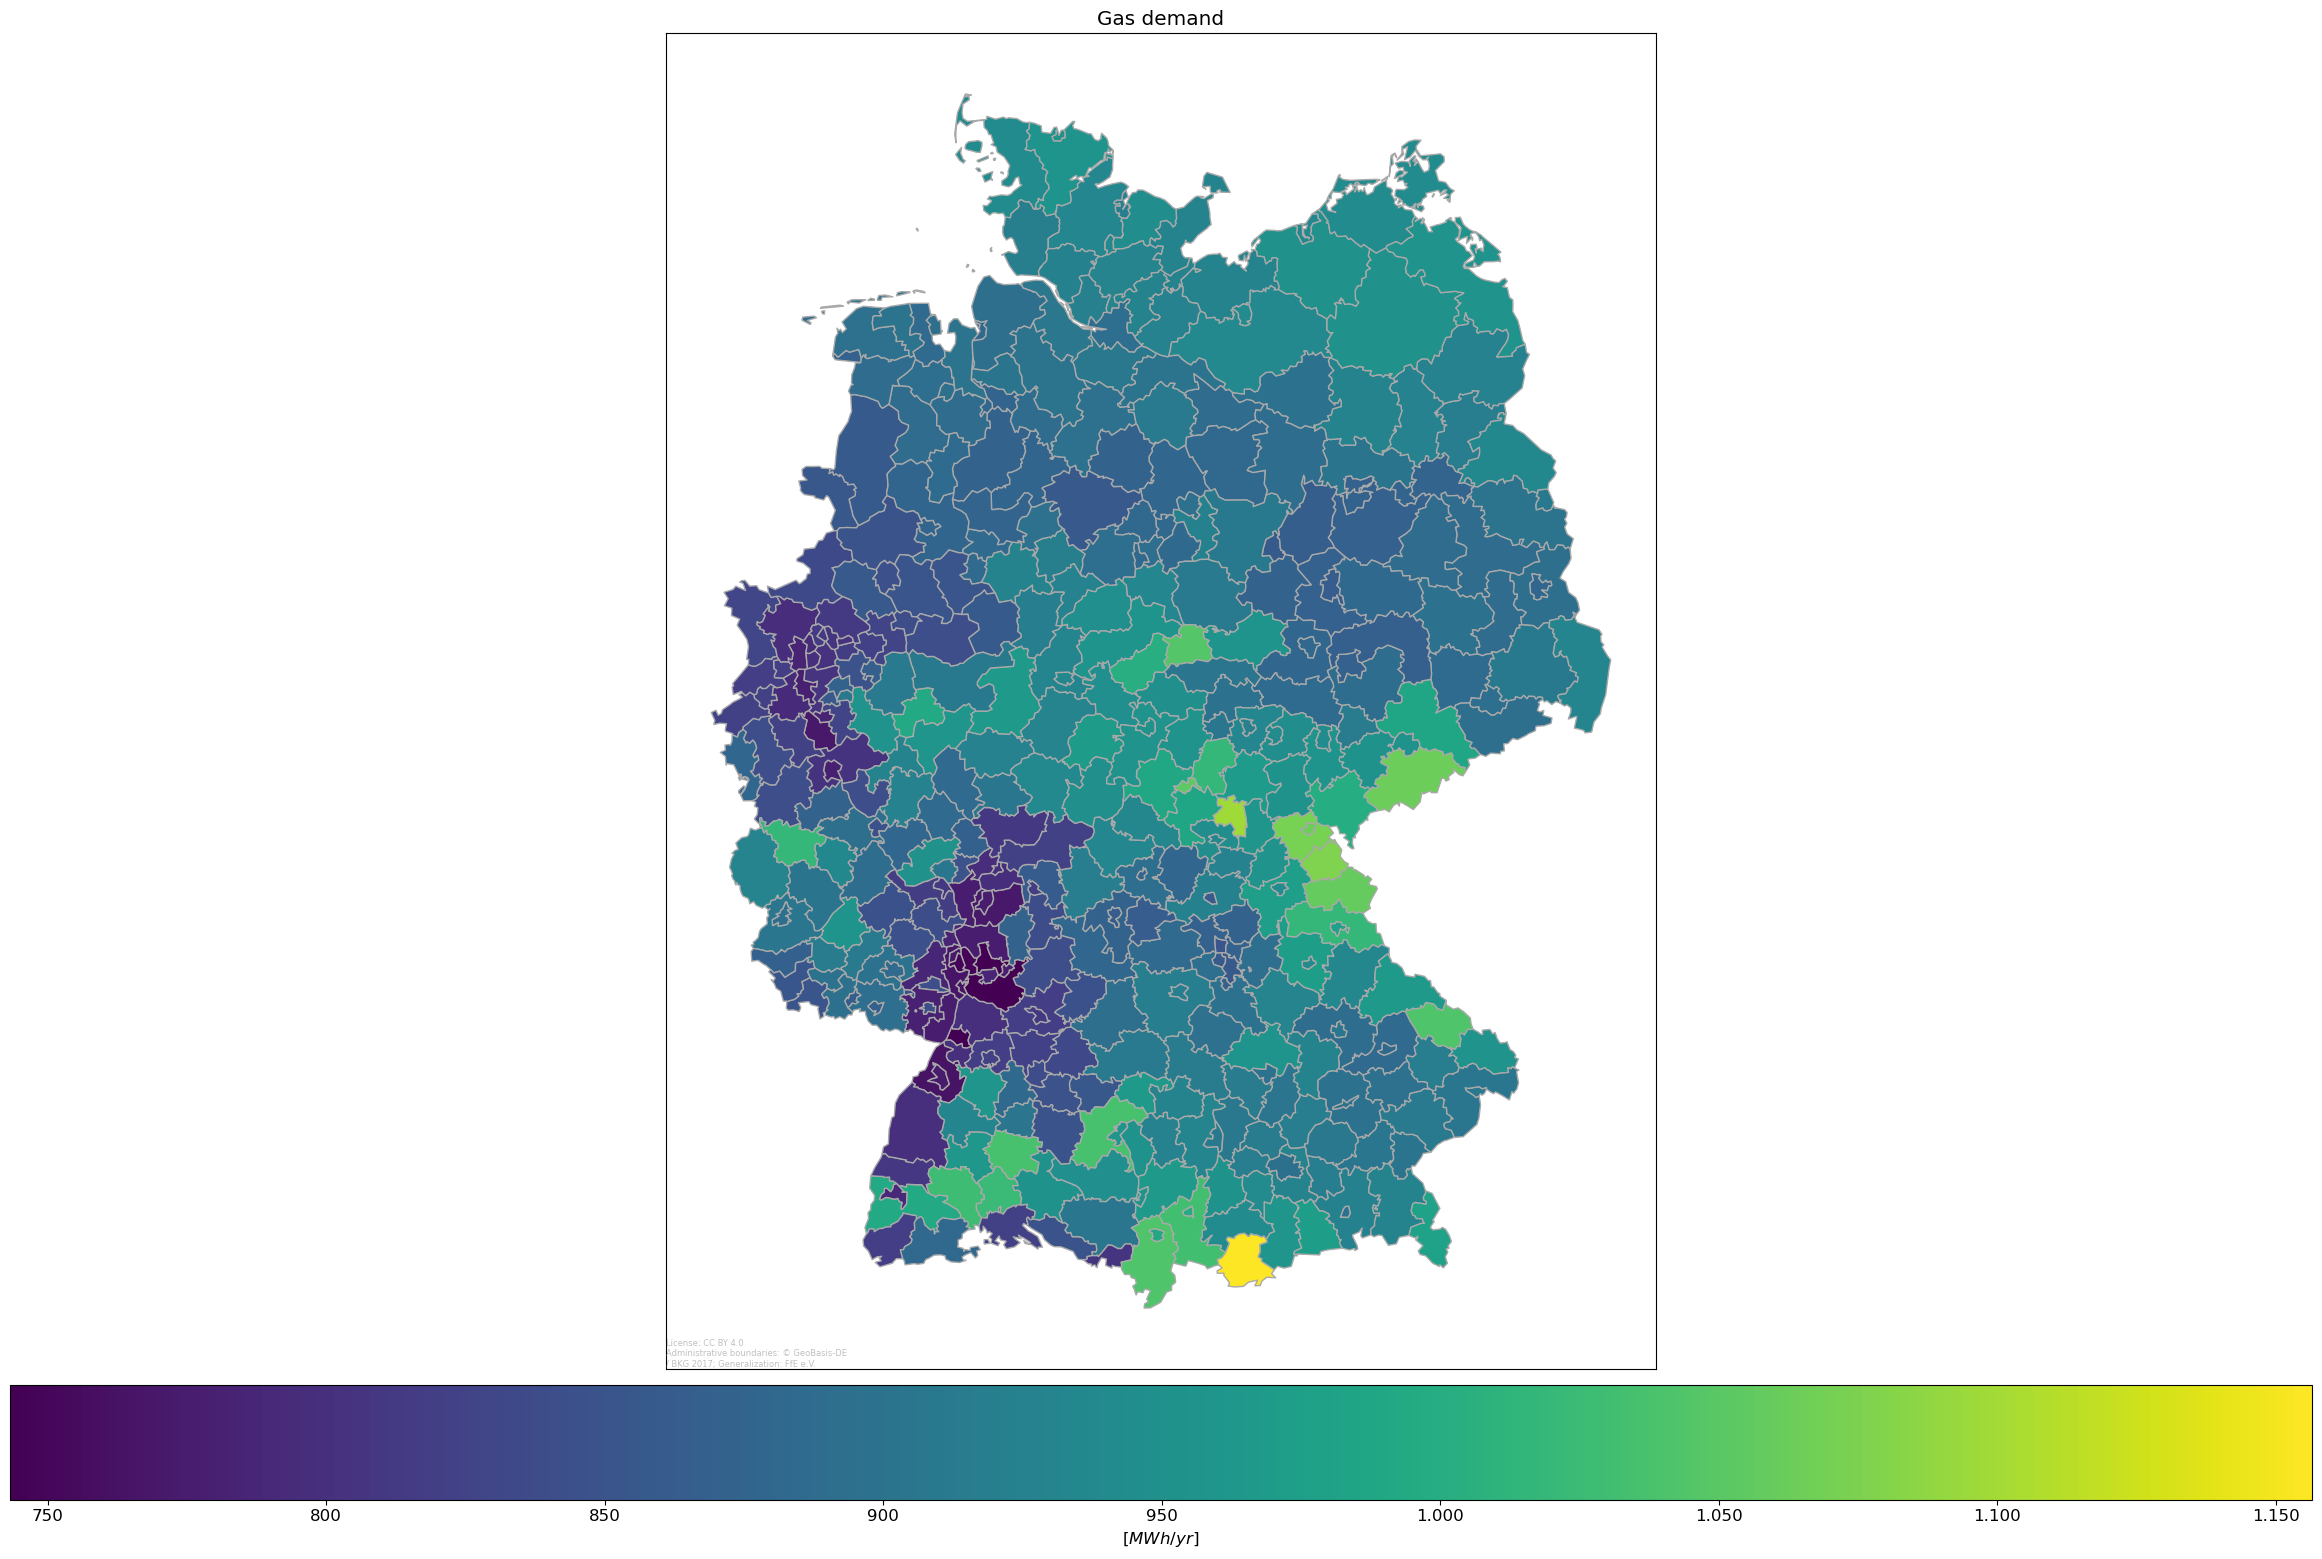

In [8]:
_, _ = plot.choropleth_map(gasDemandGrouped, axtitle = "Gas demand", unit= "MWh/yr", relative = False) # Relative = divide by area

And we compute the hydrogen demand as a function of the % of blending.

**TODO : REDUCE THE blending PERCENTAGE**

In [9]:
#hydrogenDemand = gasDemandGrouped * 1000 / 365 # kWh/d

#b = 0.5 # % of H2

#HVch4 = 14.583 # kWh / kgCH4
#HVh2  = 33.33  # kWh / kgH2

#hydrogenDemand = hydrogenDemand / ( ( (1 - b) / b) * HVch4 + HVh2)

## Industrial demand

As previously, we bring the industry demand and merge the data.

In [10]:
files = ["amonia.json", "refineries.json", "steel.json"]

importData = []

for file in files:
    with open("project_data/in/" + file, 'r', encoding = "utf-8") as f:
        importData.append(json.load(f))

toDelete = []
points = []

for dataE in importData:
    temp = []
    for element in dataE:
        if (element["Latitude"] == ""):
            toDelete.append(element)
            continue
          
        if (i == 1 and element["Product"] != "Crude"): # Keep only the crude production
            toDelete.append(element)
            continue
        
        if (i == 2 and element["Process"] == "Electric"): # Keep only high furnaces
            toDelete.append(element)
            continue
        
        element["geometry"] = [float(element["Longitude"]), float(element["Latitude"])]

        del element["Latitude"]
        del element["Longitude"]
        
        temp.append(Point(element["geometry"][0], element["geometry"][1]))
    points.append(temp)

for toD in toDelete: # Delete the industry that doesn't have coordinates
    for dataE in importData:
        if (not toD in dataE): continue
        dataE.remove(toD)

amonia = copy.deepcopy(importData[0])
refineries = copy.deepcopy(importData[1])
steel = copy.deepcopy(importData[2])

aPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[0]), crs = "EPSG:4326")
rPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[1]), crs = "EPSG:4326")
sPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[2]), crs = "EPSG:4326")

aPoints = aPoints.to_crs("EPSG:25832")
rPoints = rPoints.to_crs("EPSG:25832")
sPoints = sPoints.to_crs("EPSG:25832")

aPoints["consumption"] = [(int(a["Production"]) * 1000 * 176.14 / 1000 / 365) for a in amonia]          # In kgH2 / d
rPoints["consumption"] = [(int(r["Production"]) * 1000 * 1.02 / 227.69 / 365) for r in refineries]      # In kgH2 / d
sPoints["consumption"] = [(int(s["Production"]) * 1000 * 0.97 * 54.171367 / 1000 / 365) for s in steel] # In kgH2 / d

aPoints = gpd.sjoin(aPoints, nuts)
rPoints = gpd.sjoin(rPoints, nuts)
sPoints = gpd.sjoin(sPoints, nuts)

# hydrogenDemand["value"] = pipesDestination["comingIn"] * hydrogenDemand["value"]

# for index, row in aPoints.iterrows():
    # hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]
    
# for index, row in rPoints.iterrows():
    # hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

# for index, row in sPoints.iterrows():
    # hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

# if ("XX" in list(hydrogenDemand.index)): hydrogenDemand = hydrogenDemand.drop("XX")

# with open("project_data/out/hydrogenDemand.json", 'w') as file:
    # json.dump(hydrogenDemand.to_dict(), file)
    
    # hydrogenDemand["value"] = pipesDestination["comingIn"] * hydrogenDemand["value"]
    
    # for index, row in aPoints.iterrows():
        # hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    # for index, row in rPoints.iterrows():
        # hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    # for index, row in sPoints.iterrows():
        # hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    # if ("XX" in list(hydrogenDemand.index)): hydrogenDemand = hydrogenDemand.drop("XX")


In [11]:
def computeHydrogenDemand(b): # Where b between 0-1 is the percentage of blending
    hydrogenDemand = gasDemandGrouped * 1000 / 365 # kWh/d
    
    HVch4 = 14.583 # kWh / kgCH4
    HVh2  = 33.33  # kWh / kgH2

    hydrogenDemand = hydrogenDemand / ( ( (1 - b) / b) * HVch4 + HVh2)
    
    hydrogenDemand["value"] = pipesDestination["comingIn"] * hydrogenDemand["value"]
    
    for index, row in aPoints.iterrows():
        hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    for index, row in rPoints.iterrows():
        hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    for index, row in sPoints.iterrows():
        hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    if ("XX" in list(hydrogenDemand.index)): hydrogenDemand = hydrogenDemand.drop("XX")
        
    threshold = 0.5 * sum(list(hydrogenDemand["value"].values))
    
    centroidData = np.column_stack((nuts.centroid.x, nuts.centroid.y, hydrogenDemand["value"].values)) # Coords of the points
    
    return threshold, hydrogenDemand, centroidData

## Demand analysis

If we analyse the yearly demand of hydrogen considering 100% blending (meaning no natural gas), we find that the total hydrogen demand reaches 128 TWh. Which is close to the expected demand of 130 TWh found in [this](https://www.reuters.com/business/energy/german-cabinet-approves-updated-national-hydrogen-strategy-2023-07-26/) article.

> But even with doubling the country's domestic electrolysis capacity target for 2030 to at least 10 gigawatts (GW), Germany will need to import around 50% to 70% of its hydrogen demand, forecast at 95 to 130 TWh in 2030, the strategy showed.

In [ ]:
365 * hydrogenDemand.sum() * 39.39 / 1e9 #  kgH2/d -> kWh/d -> TWh/yr

## CAPEX, OPEX and TOTEX

With the hydrogen demand computed, we can declare the same equations for the CAPEX, OPEX and TOTEX.

In [12]:
with open("project_data/in/connections_O_10.json", 'r') as file:
    Connections = json.load(file)

In [13]:
def computeCentroids(n, centroidData):
    max_demand = np.max(centroidData[:, 2]) # Normalize the energy demand
    centroidData[:, 2] /= max_demand
    
    # Create a weight array where the weight is the energy demand
    weights = centroidData[:, 2]

    # Perform weighted k-means clustering
    kmeans = KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(centroidData[:, :2], sample_weight=weights)

    return kmeans.cluster_centers_ # Centroids of the clusters

def electrolysisCAPEX(outC): # outC is the output capacity in kg/d
    m = outC / 24 # kg/hr
    
    CAPEX = 224.49 * m**(0.6156) # https://www.nrel.gov/docs/fy09osti/44103.pdf p.21
    CAPEX *= 1000 # In 2008 dollars
    
    CEPCI2022 = 798.3 # 07.2023
    CEPCI2008 = 575.4 #    2008
    
    return CAPEX * (CEPCI2022 / CEPCI2008)

def electrolysisOPEX(outC):
    totalEnergy = outC * 365 / 39.39 # kWh/yr
    return 50 * 0.94 * outC # Assuming a 50$/kWh of the CAPEX (worst case) [https://theicct.org/wp-content/uploads/2021/06/final_icct2020_assessment_of-_hydrogen_production_costs-v2.pdf p.27]

def electrolysisTOTEX(outC):
    return electrolysisCAPEX(outC) + electrolysisOPEX(outC)

### Load distribution and CAPEX calculation

Here we divide the load of all the plants as evenly as possible.

In [14]:
def generate_combinations(elements):
    if (len(elements) == 0): return []

    combinations = [[]]

    for element_list in elements:
        new_combinations = []
        for combination in combinations:
            for element in element_list:
                new_combination = combination.copy()
                new_combination.append(element)
                new_combinations.append(new_combination)
        combinations = new_combinations

    return combinations

def getDistancePath(path): # Returns the length of a path by adding the length between all the points inside of a path
    distance = 0
    
    for i in range(len(path) - 1):
        distance += pipesLengths[path[i]][path[i + 1]]
    
    return distance

def getDestinations(node): # Returns all the districts accessible to a district
    temp = []
    
    for n in Connections[node]:
        if (Connections[node][n] != None): temp.append(n)
    
    return temp

districtsCentroids = gpd.GeoDataFrame(geometry = nuts.centroid, crs = "EPSG:25832")

def computeCapex(plantsLocations, hydrogenDemand):
    n = len(plantsLocations)
    minProdPerPlant = threshold / n # How much each plant should produce kgH2/d
    contributions = [0] * n         # How much each plant procudes in kgH2/d
    
    # Compute the energy demand without duplicates
    servingPlaces = [getDestinations(plant) for plant in plantsLocations]
    duplicates = [] # Structure : [[index1, index2, NUTS3 district], ...]
    
    # Find the duplicates
    for i in range(n): # For each plant
        for serv in servingPlaces[i]: # For each place that the plant i serves, we need to check if it is already in a different place
            for j in range(i + 1, n):
                if (serv in servingPlaces[j]):
                    duplicates.append([i, j, serv])
    
    toRemove = [] # Structure : [ [plant (index), location to remove (NUTS3), length],  ...]
    
    for dup in duplicates:
        dist1 = getDistancePath(Connections[plantsLocations[dup[0]]][dup[2]])
        dist2 = getDistancePath(Connections[plantsLocations[dup[1]]][dup[2]])
        
        if (dist1 > dist2): toRemove.append([dup[0], dup[2], dist1])
        else:               toRemove.append([dup[1], dup[2], dist2])
    
    toRemove = sorted(toRemove, key=lambda x: x[2])
    
    max_energy = [sum(hydrogenDemand.loc[dest, "value"] for dest in servingPlaces[i]) for i in range(n)]
    
    # Decide the power each one can give (first we compute)
    excess = 0
    for i in range(n):
        plant_share = minProdPerPlant
        if (plant_share <= max_energy[i]):
            contributions[i] = plant_share
        else:
            contributions[i] = max_energy[i]
            excess += plant_share - max_energy[i]
            remaining_plants = [j for j in range(n) if j < i]
            
            for j in remaining_plants:
                if (excess > 0 and contributions[j] < max_energy[j]):
                    available_capacity = max_energy[j] - contributions[j]
                    additional_contribution = min(available_capacity, excess)
                    contributions[j] += additional_contribution
                    excess -= additional_contribution
    
    if (excess > 0): # It may happen that all the excess haven't been distributed since the previous loop just goes backwards to not interfere
        for i in range(n):
            available_capacity = max_energy[i] - contributions[i]
            additional_contribution = min(available_capacity, excess)
            contributions[i] += additional_contribution
            excess -= additional_contribution
            
            if (excess == 0): break # If the excess is already 0, don't bother continuing
    
    # Compute the price
    CAPEX = [0] * n
    for i in range(len(contributions)):
        CAPEX[i] = electrolysisCAPEX(contributions[i])
    
    return CAPEX, sum(CAPEX), contributions, servingPlaces

## Optimization

It's time for some minima

In [ ]:
def create_circle(center_x, center_y, radius, num_points = 25): # Returns a MultiPolygon circle shape
    circle_points = []
    
    for i in range(num_points):
        angle = 2 * np.pi * i / (num_points - 1)
        
        x = center_x + radius * np.cos(angle)
        y = center_y + radius * np.sin(angle)
        
        circle_points.append((x, y))

    return MultiPolygon([Polygon(circle_points)])

indexes = list(nuts.index)

def getDistance(point1, point2):
    return math.sqrt( (point1.x - point2.x)**2 + (point1.y - point2.y)**2 )

maxRadius = 1e9

maxClusters = 50

for b in [1, 0.75, 0.5, 0.35, 0.25]:
    print("Updating the hydrogen demand for a", 100*b, "% of blending")
    
    threshold, hydrogenDemand, centroidData = computeHydrogenDemand(b)
    
    print("The current threshold is set at", threshold)

    # For each number of nodes
    plantsCosts = []          # The CAPEX of each plant
    plantsServings = []       # The districts each plant serves
    plantsLocations = []      # The locations of each plant
    plantsSpecifications = [] # The contribution of each plant to the H2 grid

    for n in range(3, maxClusters + 1):
        print("Finding", n, "plants locations")

        currentPrice = float("inf") # Start with a large number to ensure that the first to be a real number is taken

        plantsCosts.append([])
        plantsServings.append([])
        plantsLocations.append([])
        plantsSpecifications.append([])

        clusterCentroids = computeCentroids(n, centroidData) # Find the n centroids

        R = [10] * n
        while (currentPrice == float("inf")):
            pointsToConsider = []

            for i, point in enumerate(clusterCentroids):
                pointsToConsider.append([])

                while (len(pointsToConsider[i]) == 0):
                    pointArea = create_circle(point[0], point[1], R[i])
                    pointsToConsider[i] = gpd.sjoin(nuts, gpd.GeoDataFrame(geometry=[pointArea], index = ["YEP"], crs = "EPSG:25832"), how = "left")
                    pointsToConsider[i] = list(pointsToConsider[i]["index_right"][pointsToConsider[i]["index_right"] == "YEP"].index)

                    # Clean the useless results
                    for j in range(len(pointsToConsider[i]) - 1, -1, -1):
                        if (not pointsToConsider[i][j] in Connections): del pointsToConsider[i][j]

                    if (len(pointsToConsider[i]) == 0): R[i] *= 2

            # Check that no two lists have the same locations where a plant can be placed
            toCompare = [] # Structure : [ [index1, index2, NUTS3 district], ...]

            for i in range(n):
                for point in pointsToConsider[i]:
                    for j in range(i + 1, n):
                        if (point in pointsToConsider[j]):
                            toCompare.append([i, j, point])

            for comp in toCompare:
                dist1 = getDistance(Point(clusterCentroids[comp[0]][0], clusterCentroids[comp[0]][1]), districtsCentroids.loc[comp[2], "geometry"])
                dist2 = getDistance(Point(clusterCentroids[comp[1]][0], clusterCentroids[comp[1]][1]), districtsCentroids.loc[comp[2], "geometry"])

                if (dist1 > dist2): del comp[1]
                else:               del comp[0]

            # Delete the duplicates that are further from the center
            for comp in toCompare:
                if (comp[1] in pointsToConsider[comp[0]]): pointsToConsider[comp[0]].remove(comp[1])
            
            combinations = generate_combinations(pointsToConsider)
            
            if (len(combinations) > 50000): counter = 100
            
            for comb in combinations: # for each point combination
                dests = []
                
                for i in range(n):
                    dests = dests + getDestinations(comb[i])
                
                dests = list(set(dests))
                
                val = 0
                for d in dests:
                    val += hydrogenDemand.loc[d, "value"]

                if (val < threshold): continue # The production of the plants wouldn't cover 50% of the german demand

                CAPEXES, CAPEX, contr, serving = computeCapex(comb, hydrogenDemand) # Compute the CAPEX and all the associated values

                #distances = [] # List with the distances from every plant to every destination it serves

                #for i in range(len(comb)):
                    #for j in range(len(serving[i])):
                        #distances.append(getDistancePath(Connections[comb[i]][serving[i][j]]))

                #totalDistance = np.mean(np.array(distances))

                if (CAPEX < currentPrice):
                    currentPrice = CAPEX
                    print("Found", 100 - counter)
                    plantsCosts[-1]          = CAPEXES
                    plantsServings[-1]       = serving
                    plantsLocations[-1]      = comb
                    plantsSpecifications[-1] = contr
                    
                    if (counter > 0): # This is only for large number of combinations
                        counter -= 1
                        
                        if (counter == 0):
                            print("100 optimal places have been found, get out")
                            break

            R = [r * 2 for r in R] # Increase the radius times 2 still no point has been found

            if (max(R) > maxRadius):
                print("Failed for", n, "plants")
                break # Limit the radius of the search
        optimalPlaces = {}

        optimalPlaces["costs"] = plantsCosts
        optimalPlaces["servings"] = plantsServings
        optimalPlaces["locations"] = plantsLocations
        optimalPlaces["specifications"] = plantsSpecifications


    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json", 'w') as file:
        json.dump(optimalPlaces, file)

Updating the hydrogen demand for a 100 % of blending
The current threshold is set at 4479116.761933945
Finding 3 plants locations
Found 0
Finding 4 plants locations
Found 1
Found 2
Finding 5 plants locations
Found 0
Found 1
Found 2
Found 3
Found 4
Finding 6 plants locations
Found 0
Found 1
Found 2
Found 3
Found 4
Found 5
Found 6
Found 7
Finding 7 plants locations
Found 8
Finding 8 plants locations
Found 9
Finding 9 plants locations
Found 10
Finding 10 plants locations
Found 11
Found 12
Found 13
Found 14


In [ ]:
optimalPlaces = {}

optimalPlaces["costs"] = plantsCosts
optimalPlaces["servings"] = plantsServings
optimalPlaces["locations"] = plantsLocations
optimalPlaces["specifications"] = plantsSpecifications

with open("project_data/out/optimalPlaces_criteria_minTotex.json", 'w') as file:
    json.dump(optimalPlaces, file, indent = 4)

In [19]:
print(combinations.index(comb) / len(combinations))

0.11850650498122825
